In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from textblob import TextBlob
import os
import re
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import nan

import nltk
from nltk.corpus import stopwords
#print(os.listdir("/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Data/Updates"))

The next step converts to datetime65 format and sorts by date.

In [2]:
src = "/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Data/Greenwashing"

fields = ['created_at', 'text']

df = pd.read_csv(join(src, 'greenwashing.csv'), encoding='utf-8', dtype='unicode', 
                   parse_dates=['created_at'], usecols=fields)

# df['text'].head()

In [3]:
# Standard cleaning tasks

my_stopwords = nltk.corpus.stopwords.words('german', 'english')

def remove_links(tweet):
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # remove bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('RT @[\w_]+:', '', tweet) # remove retweet ## Alternatives: RT @[\w_]+: OR (RT\s@[A-Za-z]+[A-Za-z0-9-_]+)
    tweet = re.sub('@[A-Za-z0-9_]', '', tweet) # remove tweeted at ## Alternatives: @[A-Za-z0-9_]+ OR (@[A-Za-z]+[A-Za-z0-9-_]+)
    return tweet

# cleaning master function
def clean_tweet(tweet): 
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub(r'[^\w\s]', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet, re.UNICODE) # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet, re.UNICODE) # remove numbers
    
    return tweet
df = df.dropna(subset=['text']) # delete empty rows
df['clean_text'] = df['text']
df['clean_text'] = df.clean_text.apply(clean_tweet)
df['clean_text'].head(5)

0    apollon ulysse sisyphe depuis  ans le mythe fe...
1    vallois harlesharoche ehuffpost ogerfederer om...
2    confused about greenwashing greenwashing is wh...
3     confused about greenwashing greenwashing is w...
4                                                     
Name: clean_text, dtype: object

In [5]:
reindexed_data = df['clean_text']
#reindexed_data.index = pd.DatetimeIndex(pd.date_range(start='2021-06-07', end='2021-07-05 23:00:00', freq="1h"))

df['dates'] = pd.to_datetime(df['created_at'].astype('datetime64[ns]').dt.tz_localize('UTC').dt.tz_convert('Europe/Berlin').dt.tz_localize(None))
reindexed_data.index = df['dates']
#reindexed_data.head()

Now we generate coloumns based on keywords. Check additional research prior to this on which terms may make sense. (Qualitative coding, topic modelling, etc.)

In [17]:
protest = [0]*reindexed_data.shape[0]
climateaction = [0]*reindexed_data.shape[0]
# inauthentic = [0]*reindexed_data.shape[0] # Tested but turned out irrelevant
misleading = [0]*reindexed_data.shape[0]
truth = [0]*reindexed_data.shape[0]
misinformation = [0]*reindexed_data.shape[0]
disinformation = [0]*reindexed_data.shape[0]
# incorrect = [0]*reindexed_data.shape[0] # Tested but turned out irrelevant
fake = [0]*reindexed_data.shape[0]
pinkwashing = [0]*reindexed_data.shape[0]
# deforestation = [0]*reindexed_data.shape[0] # I exclude this data set, because it's peaks are too hiugh.
fridaysforfuture = [0]*reindexed_data.shape[0]

for i in range(reindexed_data.shape[0]):
    words = TextBlob(reindexed_data[i]).words
    for word in words:
        if word == "protest" or word == "protesting": protest[i]=1
        if word == "climateaction": climateaction[i]=1
        #if word == "incorrect": incorrect[i]=1
        #if word == "inauthentic": inauthentic[i]=1
        if word == "true" or word == "truth": truth[i]=1
        if word == "fake": fake[i]=1
        if word == "misinformation": misinformation[i]=1
        if word == "disinformation": disinformation[i]=1
        if word == "misleading": misleading[i]=1
        if word == "pinkwashing": pinkwashing[i]=1
        #if word == "deforestation": deforestation[i]=1
        if word == "fridaysforfuture": fridaysforfuture[i]=1
keywords = pd.DataFrame({'clean_text':reindexed_data,
                        'protest':protest,
                        #'incorrect':incorrect,
                        'misinformation':misinformation,
                        'disinformation':disinformation,
                        'climateaction':climateaction,
                        #'inauthentic':inauthentic,
                        'truth':truth,
                        'fake':fake,
                        'misleading':misleading,
                        'pinkwashing':pinkwashing,
                        #'deforestation':deforestation,
                        'fridaysforfuture':fridaysforfuture}
                        ,index=reindexed_data.index)
                        
#keywords.head

In [18]:
daily = keywords.resample('D').sum()
# monthly = keywords.resample('M').sum()
daily = daily.loc['2020-07-01':'2021-07-06'].reset_index() # Set time frame
daily.head()

,dates,protest,misinformation,disinformation,climateaction,truth,fake,misleading,pinkwashing,fridaysforfuture
0,2020-07-01,0,0,0,1,6,0,3,1,0
1,2020-07-02,0,0,0,0,2,2,2,0,0
2,2020-07-03,0,0,2,4,1,0,7,0,0
3,2020-07-04,0,0,0,0,1,1,1,0,0
4,2020-07-05,0,0,0,0,1,0,1,1,1


In [19]:
# transform from wide to long

melted = daily.melt(id_vars=['dates'])
melted

,dates,variable,value
0,2020-07-01,protest,0
1,2020-07-02,protest,0
2,2020-07-03,protest,0
3,2020-07-04,protest,0
4,2020-07-05,protest,0
...,...,...,...
3334,2021-07-02,fridaysforfuture,2
3335,2021-07-03,fridaysforfuture,6
3336,2021-07-04,fridaysforfuture,11
3337,2021-07-05,fridaysforfuture,5


## Let's test some subplots

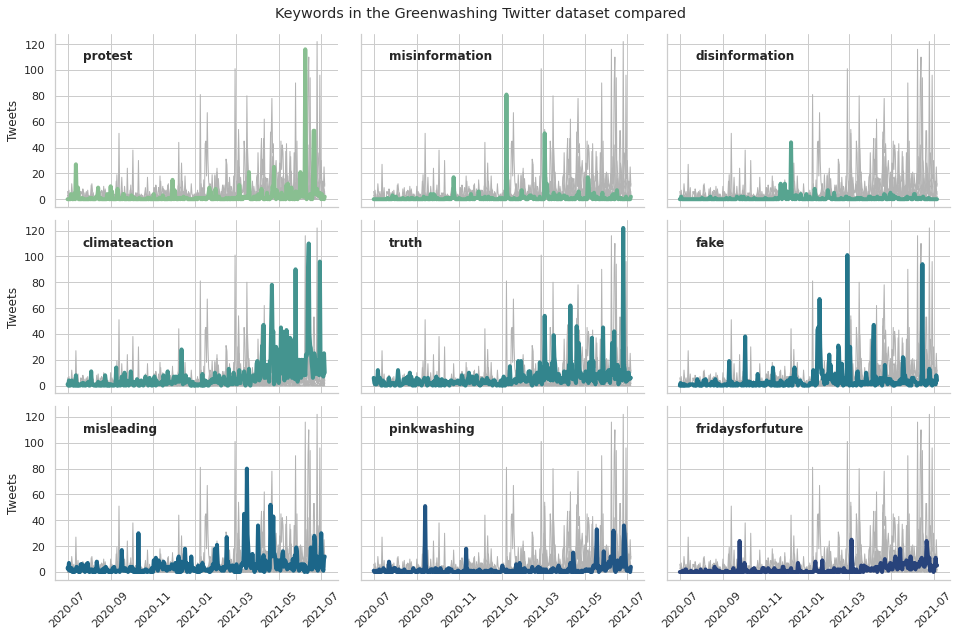

In [30]:
import seaborn as sns

sns.set_theme(style="whitegrid")

# Plot each year's time series in its own facet
g = sns.relplot(
    data=melted,
    x="dates", y="value", col="variable", hue="variable",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=3, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for category, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.1, .85, category, transform=ax.transAxes, fontweight="bold")
    
    # Plot every year's time series in the background
    sns.lineplot(
        data=melted, x="dates", y="value", units="variable",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )
#ax.set_xticks([pd.to_datetime(t) for t in ['2020-06-01', '2021-06-01']]) 

g.fig.suptitle('Keywords in the Greenwashing Twitter dataset compared')
g.set_xticklabels(rotation=45)
# Reduce the frequency of the x axis ticks
#ax.set_xticks(ax.get_xticks()[::])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Tweets")
g.tight_layout()
g.savefig("/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/plots/Greenwashing/keywords.svg")

Here's the issue: datetype not set.

AttributeError: 'Figure' object has no attribute 'set_xlim'

<Figure size 2280x1520 with 0 Axes>

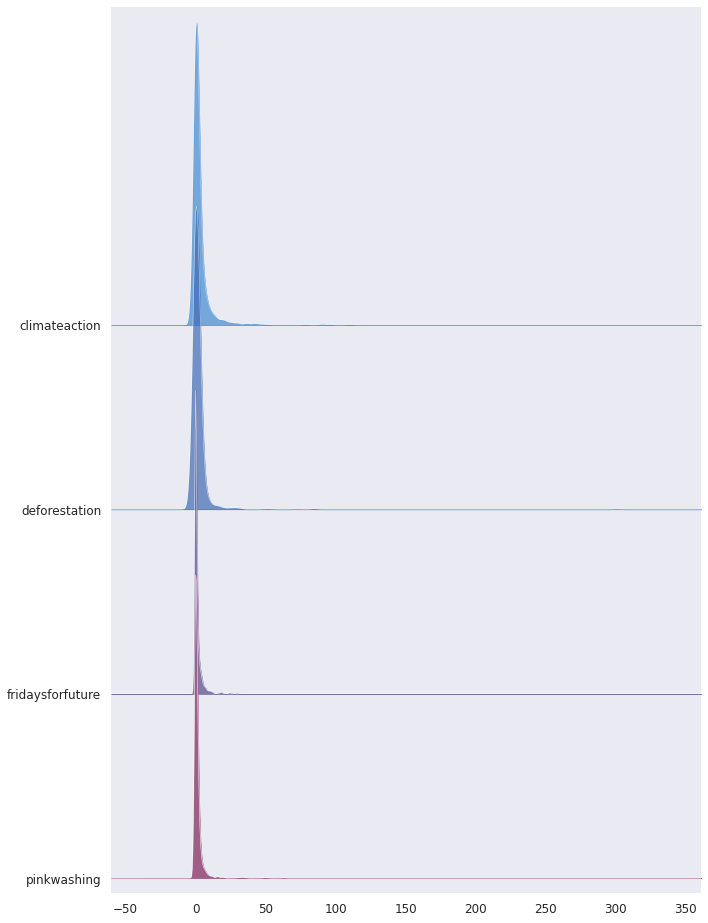

In [143]:
#import the libraries
import pandas as pd
import joypy
import numpy as np
import matplotlib.pyplot as plt 

#set some display options

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def color_gradient(x=0.0, start=(0, 0, 0), stop=(1, 1, 1)):
    r = np.interp(x, [0, 1], [start[0], stop[0]])
    g = np.interp(x, [0, 1], [start[1], stop[1]])
    b = np.interp(x, [0, 1], [start[2], stop[2]])
    return (r, g, b)

#plot the figure
plt.figure(dpi=380)
fig, axes = joypy.joyplot(melted
                          , column=['dates', 'value']
                          , overlap=2.5
                          , by="variable"
                          , ylim='own'
                          #, x_range=(0,15)
                          , fill=True
                          , figsize=(10,13)
                          , legend=False
                          , xlabels=True
                          , ylabels=True
                          #, color=['#76a5af', '#134f5c']
                          , colormap=lambda x: color_gradient(x, start=(.08, .45, .8)
                                                             ,stop=(.8, .34, .44))
                          , alpha=0.6
                          , linewidth=.5
                          , linecolor='w'
                          #, background='k' # change to 'k' for black background or 'grey' for grey
                          , fade=True)

plt.title('Joy Plot of City and Highway Mileage by Class'
          , fontsize=14
          , color='grey'
          , alpha=1)

plt.rc("font", size=12)
plt.xlabel('Date', fontsize=14, color='grey', alpha=1)
plt.ylabel('Tweets', fontsize=8, color='grey', alpha=1)
plt.show

## Alternative

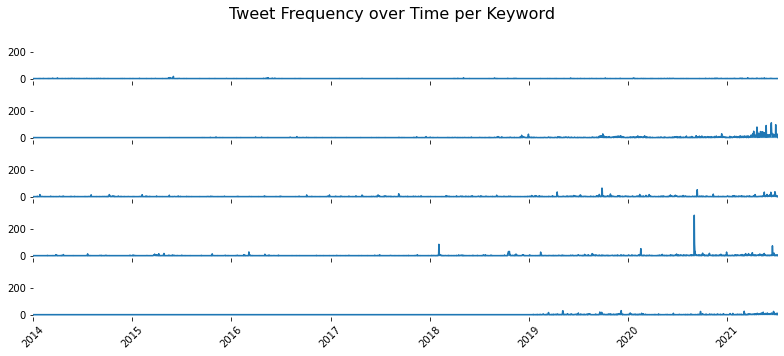

In [27]:
# Generate a seaborn plot with subplots, all sharing the first plot's x axis. 

import seaborn

fig, ax = plt.subplots(5, sharex=True, sharey=True, figsize=(11,5))

fig.suptitle('Tweet Frequency over Time per Keyword', fontsize=16)

# Add subplots 

ax[0].plot(daily['greenmarketing'], label='greenmarketing');
ax[0].fill_between(daily.index, daily['greenmarketing'], color='#539ecd')
#ax[0].text(pd.to_datetime('2014-05-31'), 250, '#greenmarketing', fontsize=12, color='#1f77b4')
ax[0].set_xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2021-07-06')) # Set dates on x axes
#ax[0].set_title('greenmarketing')

ax[1].plot(daily['climateaction'], label='climateaction');
ax[1].fill_between(daily.index, daily['climateaction'], color='#539ecd')
#ax[1].text(pd.to_datetime('2014-05-31'), 250, 'climateaction', fontsize=12, color='#1f77b4')
#ax[1].set_title('climateaction')

#ax[2].plot(daily['greenwashing'], label='greenwashing');
#ax[2].fill_between(daily.index, daily['greenwashing'], color='#539ecd')
#ax[2].text(pd.to_datetime('2014-05-31'), 250, 'greenwashing', fontsize=12, color='#1f77b4')
#ax[2].set_title('climateaction')

ax[2].plot(daily['pinkwashing'], label='pinkwashing');
ax[2].fill_between(daily.index, daily['pinkwashing'], color='#539ecd')
#ax[2].text(pd.to_datetime('2014-05-31'), 250, 'pinkwashing', fontsize=12, color='#1f77b4')
#ax[2].set_title('pinkwashing')

ax[3].plot(daily['deforestation'], label='deforestation');
ax[3].fill_between(daily.index, daily['deforestation'], color='#539ecd')
#ax[3].text(pd.to_datetime('2014-05-31'), 250, 'deforestation', fontsize=12, color='#1f77b4')
#ax[3].set_title('deforestation')

ax[4].plot(daily['fridaysforfuture'], label='fridaysforfuture');
ax[4].fill_between(daily.index, daily['fridaysforfuture'], color='#539ecd')
#ax[4].text(pd.to_datetime('2014-05-31'), 250, 'FridaysForFuture', fontsize=12, color='#1f77b4')
#ax[4].set_title('FridaysForFuture')


#plt.xticks([pd.to_datetime('2021-06-09'), pd.to_datetime('2021-06-14'), pd.to_datetime('2021-06-19'), pd.to_datetime('2021-06-24'), pd.to_datetime('2021-06-29'), pd.to_datetime('2021-07-04')])
plt.xticks(rotation=45)

t = np.arange(0, 1, 0.01)

for i, a in enumerate(ax):
    a.plot(t, np.sin((i + 1) * 2 * np.pi * t))

seaborn.despine(left=True, bottom=True, right=True)

fig.tight_layout()
#fig.savefig('../tweet_freq_keywords.png', dpi=300)

## Word Tree

In [ ]:
import wordtree
documents = df['clean_text']
g = wordtree.search_and_draw(corpus = documents, keyword = "protest", max_per_n = 5)
g.render() # creates a file world.dv.png